# coco分类数据集代码模块check

In [1]:
import sys
import os
sys.path.append(os.path.dirname("../"))
import matplotlib.pyplot as plt

from utils.dataset import COCOClassificationDataset

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  

## 1. 加载数据集

In [ ]:
dataset = COCOClassificationDataset(
    root_dir="/root/autodl-tmp/seat_dataset/chengdu_customer",
    ann_file="/root/autodl-tmp/seat_dataset/chengdu_customer/_classification.coco.json",
    # target_categories=['褶皱（重度）', "背景"],
    min_bbox_area=5.0,
)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


## 2. 基本统计

In [3]:
from collections import Counter

# 统计每个类别的数量
label_counter = Counter()
for ann in dataset.annotations:
    cat_id = ann['category_id']
    if cat_id in dataset.cat_ids:
        label = dataset.cat_id_to_label[cat_id]
        label_counter[label] += 1

print("每个类别的样本数量统计：")
for label in range(len(dataset.cat_ids)):
    name = dataset.label_to_cat_name[label]
    count = label_counter.get(label, 0)
    print(f"  类别: {name}，数量: {count}")


每个类别的样本数量统计：
  类别: 褶皱（重度），数量: 123
  类别: 背景，数量: 170


In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from PIL import Image, ImageDraw

num_show = len(dataset)
sample_indices = list(range(min(num_show, len(dataset))))

dataset_info = [
    f"数据集样本数量: {len(dataset)}",
    f"类别数量: {dataset.get_num_classes()}",
    # f"类别名称: {dataset.get_class_names()}"
]

def get_sample_info(idx):
    i = sample_indices[idx]
    img, label, info = dataset[i]
    if not isinstance(img, Image.Image):
        img = Image.fromarray(np.array(img))
    img_size = img.size if hasattr(img, 'size') else (img.shape[1], img.shape[0]) if hasattr(img, 'shape') else "未知"
    lines = [
        *dataset_info,
        f"样本 {i}:",
        f"图片来源: {info.get('annotation_source', '未知')}",
        f"类别id: {label}",
        f"类别名称: {info.get('category_name', '未知')}",
        f"图片尺寸: {img_size} \n缺陷尺寸: ({info['bbox'][2]:.1f}, {info['bbox'][3]:.1f})"
    ]
    info_str = "\n".join(lines)
    return img, info_str

def show_sample(idx):
    img, info_str = get_sample_info(idx)
    bbox = None
    if hasattr(dataset, 'annotations') and 'bbox' in dataset.annotations[sample_indices[idx]]:
        bbox = dataset.annotations[sample_indices[idx]]['bbox']
    elif 'bbox' in dataset[sample_indices[idx]][2]:
        bbox = dataset[sample_indices[idx]][2]['bbox']
    if bbox is not None:
        draw = ImageDraw.Draw(img)
        x, y, w, h = bbox
        draw.rectangle([x, y, x + w, y + h], outline='red', width=3)
    return img, info_str

# Jupyter 交互式控件
idx_state = 0

image_widget = widgets.Output(layout=widgets.Layout(width='80%', height='200px', border='1px solid #ccc'))
info_widget = widgets.Textarea(
    value='',
    description='样本信息',
    layout=widgets.Layout(width='20%', height='400px')
)

def update_widgets(idx):
    img, info_str = show_sample(idx)
    with image_widget:
        clear_output(wait=True)
        # 自动缩放图片以适应输出区域
        max_width = 600  # 适合半页显示
        max_height = 400
        if hasattr(img, 'size'):
            w, h = img.size
            scale = min(max_width / w, max_height / h, 1.0)
            if scale < 1.0:
                img = img.resize((int(w * scale), int(h * scale)))
        display(img)
    info_widget.value = info_str

def on_prev_clicked(b):
    global idx_state
    idx_state = (idx_state - 1) % len(sample_indices)
    update_widgets(idx_state)

def on_next_clicked(b):
    global idx_state
    idx_state = (idx_state + 1) % len(sample_indices)
    update_widgets(idx_state)

prev_btn = widgets.Button(description="Previous")
next_btn = widgets.Button(description="Next")
prev_btn.on_click(on_prev_clicked)
next_btn.on_click(on_next_clicked)

# 初始显示
update_widgets(idx_state)

display(widgets.HTML("<h3>COCO 分类数据集样本浏览</h3>"))
# 图片区域80%，信息区域20%，图片至少占半页
display(widgets.HBox([info_widget, image_widget], layout=widgets.Layout(width='100%')))
display(widgets.HBox([prev_btn, next_btn]))


HTML(value='<h3>COCO 分类数据集样本浏览</h3>')

In [5]:
areas = []
for i in range(len(dataset)):
    img, label, info = dataset[i]
    x, y, w, h = info['bbox']
    area = w * h
    areas.append(area)    

In [6]:
import numpy as np
areas = np.array(areas)
areas.min(), areas.max(), areas.mean()

(26.99964201450348, 5818496.772128105, 194801.8555056508)

In [7]:
valid = areas >= 0  
if not np.all(valid):  
    print(f"Warning: {np.sum(~valid)} values < 0 were excluded.")  
areas_sqrt = np.sqrt(areas[valid])  

# 2) 计算分桶边界（将 sqrt(areas) 等宽分为 10 桶）  
num_bins = 100  
min_v, max_v = areas_sqrt.min(), areas_sqrt.max()  
# 若所有值相同，避免 bins 重合  
if min_v == max_v:  
    bins = np.linspace(min_v - 0.5, max_v + 0.5, num_bins + 1)  
else:  
    bins = np.linspace(min_v, max_v, num_bins + 1)  

# 3) 直方图统计（每桶计数）  
counts, edges = np.histogram(areas_sqrt, bins=bins)  

# 4) 计算每个桶的中心与相对频率  
centers = 0.5 * (edges[:-1] + edges[1:])  
rel_freq = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts, dtype=float)  

# 5) 打印结果  
print("Bin Edges (sqrt scale):", edges)  
print("Bin Centers (sqrt scale):", centers)  
print("Counts:", counts)  
print("Relative Frequency:", rel_freq)  

Bin Edges (sqrt scale): [   5.19611798   29.26571722   53.33531646   77.4049157   101.47451495
  125.54411419  149.61371343  173.68331267  197.75291192  221.82251116
  245.8921104   269.96170964  294.03130889  318.10090813  342.17050737
  366.24010662  390.30970586  414.3793051   438.44890434  462.51850359
  486.58810283  510.65770207  534.72730131  558.79690056  582.8664998
  606.93609904  631.00569828  655.07529753  679.14489677  703.21449601
  727.28409526  751.3536945   775.42329374  799.49289298  823.56249223
  847.63209147  871.70169071  895.77128995  919.8408892   943.91048844
  967.98008768  992.04968693 1016.11928617 1040.18888541 1064.25848465
 1088.3280839  1112.39768314 1136.46728238 1160.53688162 1184.60648087
 1208.67608011 1232.74567935 1256.81527859 1280.88487784 1304.95447708
 1329.02407632 1353.09367557 1377.16327481 1401.23287405 1425.30247329
 1449.37207254 1473.44167178 1497.51127102 1521.58087026 1545.65046951
 1569.72006875 1593.78966799 1617.85926723 1641.928866

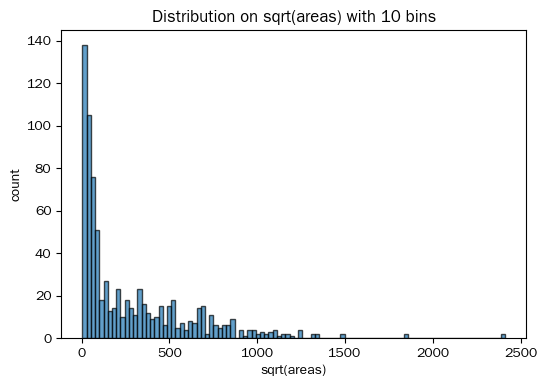

In [8]:
import pandas as pd  

df = pd.DataFrame({  
    "bin_left": edges[:-1],  
    "bin_right": edges[1:],  
    "bin_center": centers,  
    "count": counts,  
    "relative_freq": rel_freq  
})  
import matplotlib.pyplot as plt  

plt.figure(figsize=(6,4))  
# 使用条形图以自定义  
plt.bar(centers, counts, width=np.diff(edges), align="center", edgecolor="k", alpha=0.7)  
plt.xlabel("sqrt(areas)")  
plt.ylabel("count")  
plt.title("Distribution on sqrt(areas) with 10 bins")  
plt.show()